<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


Training results should now be reproducible.


# Train model

Invalidate cache entry: successful
Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.001,
    "weight_decay": 0,
    "name": "adam"
  },
  "n_epochs": 3,
  "freeze_layers": true,
  "validation_freq": 1
}


Update step:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4549, Train Acc: 91.95%, Val Acc: 99.05%
Epoch [2/3], Loss: 0.0804, Train Acc: 98.71%, Val Acc: 98.91%
Epoch [3/3], Loss: 0.0494, Train Acc: 99.18%, Val Acc: 98.91%
Total elapsed: 37.26s, average per update step: 0.10s
Training result:
{
  "training_losses": [0.45493308576228825, 0.08044520486146212, 0.04936106357237567],
  "training_accuracies": [0.9194972826086957, 0.9870923913043478, 0.9918478260869565],
  "validation_accuracies": [0.9904891304347826, 0.9891304347826086, 0.9891304347826086],
  "update_steps": [92, 184, 276],
  "epochs": [1, 2, 3],
  "training_elapsed": 37.26635304199999
}


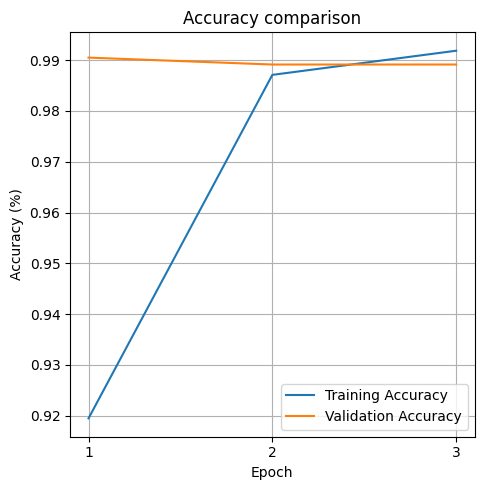

In [2]:
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams, AdamParams, FinishedAllEpochs
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    trainval_size=None,  # Load all training data
    #trainval_size=400,  # Load a subset
    validation_set_fraction=0.2,  # 20 % of trainval set
    binary=True,
)

baseline_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    n_epochs=3,
    optimizer=AdamParams(
        learning_rate=1e-3,
        weight_decay=0,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

run_args = (dataset_params, baseline_params)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=True) # set to False to enable caching

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

In [3]:
# Second plot: Rerun training multiple times with different seed
#run_with_different_seeds(dataset_params, baseline_params, trials=3)

# Test model

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.001,
    "weight_decay": 0,
    "name": "adam"
  },
  "n_epochs": 3,
  "freeze_layers": true,
  "validation_freq": 1
}


Update step:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.4570, Train Acc: 91.37%, Val Acc: 99.18%
Epoch [2/3], Loss: 0.0803, Train Acc: 98.74%, Val Acc: 99.05%
Epoch [3/3], Loss: 0.0491, Train Acc: 99.29%, Val Acc: 99.32%
Total elapsed: 36.10s, average per update step: 0.09s
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 99.32%
Number of misclassified samples: 25


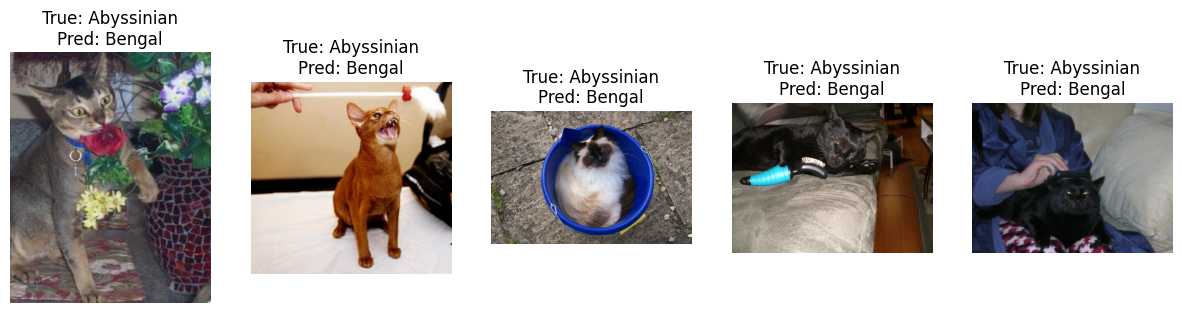

Copied 25 misclassified images to ./misclassified


In [4]:
from datasets import make_datasets
from torch.utils.data import DataLoader
from training import Trainer
from datasets import load_dataset

training_params = baseline_params

print("Training with params:")
print(training_params.pprint())
trainer = Trainer(training_params)
train_loader, val_loader = make_datasets(dataset_params, trainer.transform)
trainer.load(train_loader, val_loader)
trainer.train(stop_condition=FinishedAllEpochs())

test_dataset = load_dataset("test", Trainer.make_transform(training_params), "binary-category") # NB!
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    worker_init_fn=Determinism.data_loader_worker_init_fn(training_params.seed),
)
print(f"Test size: {len(test_loader.dataset)}")

# shows Abyssinian/Bengal instead of Cat/Dog
evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)
